In [63]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
from obspy.geodetics.base import gps2dist_azimuth,kilometer2degrees
from obspy.taup import TauPyModel
from obspy.signal.rotate import rotate_ne_rt
from matplotlib.ticker import MultipleLocator
from obspy import read, read_inventory
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
model = TauPyModel(model="iasp91")
client = Client("IRIS")

In [64]:
starttime = UTCDateTime("2013-01-01")
endtime = UTCDateTime("2015-05-01")
cat = client.get_events(starttime=starttime, endtime=endtime,
                        minmagnitude=6.5,latitude =41.115,longitude=43.8036,
                        minradius=40,maxradius=100,mindepth=100)
print(cat)

13 Event(s) in Catalog:
2015-02-27T13:45:05.640000Z |  -7.358, +122.491 | 7.0 MW
2014-12-02T05:11:31.000000Z |  +6.157, +123.126 | 6.6 MW
...
2013-04-19T03:05:52.630000Z | +46.072, +150.924 | 7.2 MW
2013-02-02T14:17:34.760000Z | +42.785, +143.147 | 6.9 MW
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [3]:
FIG_DIR = '/Volumes/home/Research/Progress/00_GO_record_plot_ZRT_0.04-0.2'
freqmin = 0.04
freqmax = 0.2
phaselist = ["Pdiff","SKS",'SKKS','Sdiff']
phasecolor= {"Pdiff":'r',
             "SKS":'b',
             "SKKS":'g',
             "Sdiff":'purple'}

In [42]:
for cata in cat[1:2]:
    plt.figure(1,figsize=(21,10))
    
    plt.rcParams['font.sans-serif']='Times New Roman'
    eq_time = cata.origins[0].time
    print(eq_time)
    eq_lon = cata.origins[0].longitude
    eq_lat = cata.origins[0].latitude
    depth  = cata.origins[0].depth/1000
    mag    = cata.magnitudes[0].mag
    mag_type = cata.magnitudes[0].magnitude_type
    
    inv = client.get_stations(network="II", station='KIV', channel="BH?",
                                    starttime=eq_time,endtime=eq_time+30*60)
    deglist = []
    for net_i in inv:
        NET = net_i.code
        for sta_i in net_i:
            STA = sta_i.code
            print(NET,STA)
            st_lat = sta_i.latitude
            st_lon = sta_i.longitude
            
            dist,azi,baz = gps2dist_azimuth(eq_lat,eq_lon,st_lat,st_lon)
            dist = dist/1000
            deg = kilometer2degrees(dist)
            deglist.append(deg)
            arrivals = model.get_travel_times(source_depth_in_km=depth,
                      distance_in_degree=deg,
                      phase_list=['P','S'])
            
            
            ori_st = client.get_waveforms(NET, STA,'*','BH?',eq_time,eq_time+30*60,attach_response=True)
            gap=ori_st.get_gaps()
            if gap != []:
                for g in gap:
                    evil_sta= g[1]
                    EVILSTA.append(evil_sta)
            st = ori_st.copy()
            st.merge(fill_value=0)
            if NET == 'II' or NET == 'IU':
                prefilt=[0.002,0.003,9,10]
            else : prefilt =[0.001, 0.005, 45, 50]
                
            st.remove_response(pre_filt =prefilt , output="DISP")

            st.detrend('linear')
            st.detrend('demean')
            st.taper(0.05,type='cosine')
            st.filter('bandpass',freqmin=freqmin,freqmax=freqmax,corners=4,zerophase=True)
            if NET == 'GO':
                HHE = st.select(component='E')[0].data
                HHN = st.select(component='N')[0].data
                HHZ = st.select(component='Z')[0].data
                HHR,HHT = rotate_ne_rt(HHN,HHE,baz)
            elif NET == 'IU' or NET == 'II' :
                HH2 = st.select(location='00', channel='BH2')[0].data
                HH1 = st.select(location='00', channel='BH1')[0].data
                HHZ = st.select(location='00', channel='BHZ')[0].data
                HHR,HHT = rotate_ne_rt(HH1,HH2,baz)

            times= st[0].times()
            HHZ=HHZ
            HHR=HHR
            HHT=HHT

2014-12-02T05:11:31.000000Z
II KIV


<Figure size 1512x720 with 0 Axes>

# origin st plot ZNE


In [43]:
ori_st.remove_response(pre_filt =prefilt , output="DISP")
ori_st.detrend('linear')
ori_st.detrend('demean')
ori_st.taper(0.05,type='cosine')
# ori_st.filter('bandpass',freqmin=freqmin,freqmax=freqmax,corners=4,zerophase=True)

E=ori_st.select(component='2',location='00')[0]
N=ori_st.select(component='1',location='00')[0]
Z=ori_st.select(component='Z',location='00')[0]
time = E.times()

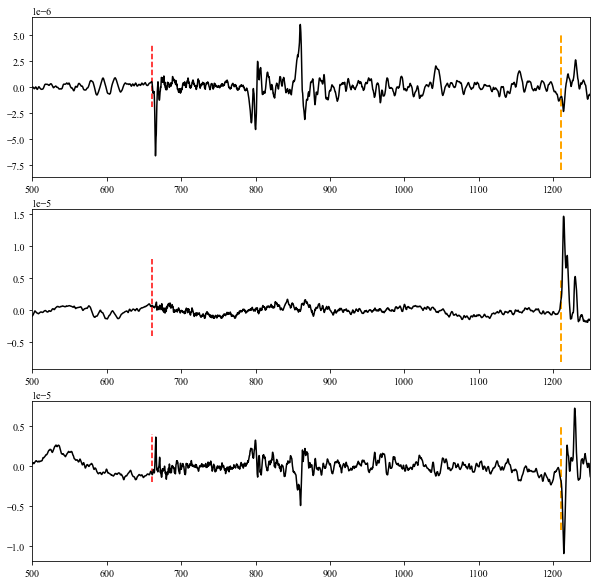

In [44]:
plt.figure(1,figsize=(10,10))
plt.subplot(311)
plt.plot(time,Z.data,'k')
plt.vlines(arrivals[0].time,-2*10**-6,4*10**-6,color='r',ls='--')
plt.xlim(500,1250)
plt.vlines(arrivals[1].time,-8*10**-6,5*10**-6,color='orange',ls='--',lw=2)
plt.subplot(312)
plt.plot(time,N.data,'k')
plt.vlines(arrivals[0].time,-4*10**-6,8*10**-6,color='r',ls='--')
plt.xlim(500,1250)
plt.vlines(arrivals[1].time,-8*10**-6,5*10**-6,color='orange',ls='--',lw=2)
plt.subplot(313)
plt.plot(time,E.data,'k')
plt.xlim(500,1250)
plt.vlines(arrivals[0].time,-2*10**-6,4*10**-6,color='r',ls='--')
plt.vlines(arrivals[1].time,-8*10**-6,5*10**-6,color='orange',ls='--',lw=2)

# plot ZRT

(500.0, 1300.0)

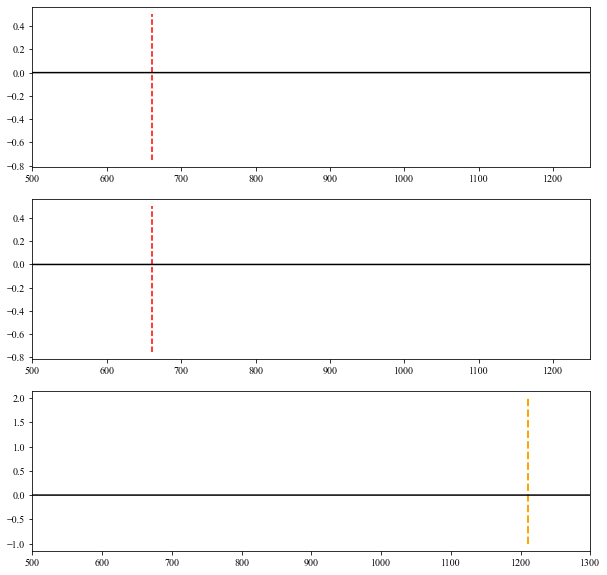

In [45]:
plt.figure(1,figsize=(10,10))
plt.subplot(311)
plt.vlines(arrivals[0].time,-0.75,0.5,color='r',ls='--')
plt.plot(times,HHZ,'k')
plt.xlim(500,1250)
plt.subplot(312)
plt.vlines(arrivals[0].time,-0.75,0.5,color='r',ls='--')
plt.plot(times,HHR,'k')
plt.xlim(500,1250)
plt.subplot(313)
plt.vlines(arrivals[1].time,-1,2,color='orange',ls='--',lw=2)
plt.plot(times,HHT,'k')
plt.xlim(500,1300)

# mseed2sac

In [8]:
E.write('/Volumes/home/Research/STEP/00_rotate_NE2RT/'+E.id+'.sac',format = 'SAC')
N.write('/Volumes/home/Research/STEP/00_rotate_NE2RT/'+N.id+'.sac',format = 'SAC')
Z.write('/Volumes/home/Research/STEP/00_rotate_NE2RT/'+Z.id+'.sac',format = 'SAC')

# read sac, write header

In [26]:
sac_st = read('/Volumes/home/Research/STEP/00_rotate_NE2RT/*.sac')

In [27]:
for tr in sac_st:
    tr.stats.sac.evla = eq_lat
    tr.stats.sac.evlo = eq_lon
    tr.stats.sac.stla = st_lat
    tr.stats.sac.stlo = st_lon
    tr.stats.sac.gcarc = deg
    tr.stats.sac.dist = dist
    tr.stats.sac.az = azi
    tr.stats.sac.baz = baz

In [28]:
BH1 = sac_st.select(component='1')[0]
BH1.stats.sac.cmpaz = 0
BH1.stats.sac.cmpinc = 90

BH2 = sac_st.select(component='2')[0]
BH2.stats.sac.cmpaz = 90
BH2.stats.sac.cmpinc = 90

BHZ = sac_st.select(component='Z')[0]
BHZ.stats.sac.cmpaz = 0
BHZ.stats.sac.cmpinc = 0

In [34]:
BH1.write('/Volumes/home/Research/STEP/00_rotate_NE2RT/'+BH1.id+'_1.sac',format = 'SAC')
BH2.write('/Volumes/home/Research/STEP/00_rotate_NE2RT/'+BH2.id+'_1.sac',format = 'SAC')
BHZ.write('/Volumes/home/Research/STEP/00_rotate_NE2RT/'+BHZ.id+'_1.sac',format = 'SAC')

In [52]:
BHR =  read('/Volumes/home/Research/STEP/00_rotate_NE2RT/*BHR_2.sac')
BHT =  read('/Volumes/home/Research/STEP/00_rotate_NE2RT/*BHT_2.sac')
BHR.filter('bandpass',freqmin=freqmin,freqmax=freqmax,corners=4,zerophase=True)
BHT.filter('bandpass',freqmin=freqmin,freqmax=freqmax,corners=4,zerophase=True)

1 Trace(s) in Stream:
II.KIV.00. | 2014-12-02T05:11:31.019500Z - 2014-12-02T05:41:30.969500Z | 20.0 Hz, 36000 samples

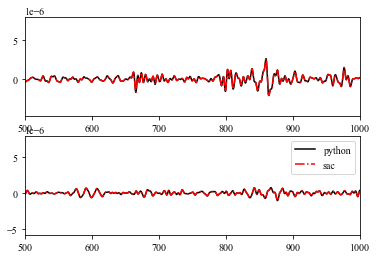

In [61]:
plt.subplot(211)
plt.plot(times,HHR,'k')
plt.plot(times,BHR[0].data,'r-.')
plt.xlim(500,1000)
plt.subplot(212)
plt.plot(times,HHT,'k',label='python')
plt.plot(times,BHT[0].data,'r-.',label='sac')
plt.xlim(500,1000)
plt.legend()